# Tomography reconstruction using TomoPy interactively

In [1]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
import matplotlib.pyplot as plt

import tifffile
import tomopy
import ipywidgets

# check variable info
def varinfo(arr):
    print arr.dtype, arr.shape, arr.min(), arr.max()

## Load images
Provide the paths for the projection, open beam and dark current images, respectively.

In [2]:
path_proj = '/Users/zhouzhou/Work/2017/TomoPy_vs_Octopus/20160630_turbineblade_Octopus/resized/turbine_*.tif'
path_ob = '/Users/zhouzhou/Work/2017/TomoPy_vs_Octopus/20160630_turbineblade_Octopus/resized/empty_*.tif'
path_dc = '/Users/zhouzhou/Work/2017/TomoPy_vs_Octopus/20160630_turbineblade_Octopus/resized/dark_*.tif'

# where you want to save the data
path_save = '/Users/zhouzhou/Work/2017/Reconstruction/tomopy/'

proj = tifffile.imread(path_proj)
ob = tifffile.imread(path_ob)
dc = tifffile.imread(path_dc)

Display the image you want to have a look at the data.

In [3]:
n_proj = proj.shape[0]
n_ob = ob.shape[0]
n_dc = dc.shape[0]

print 'There are %d projections, %d open beam images, and %d dark images.' % (n_proj, n_ob, n_dc)

def disp_im(ims, i=0, vmin=0, vmax=65536):
    if ims == 'Projections':
        data = proj
    elif ims == 'Open beam images':
        data = ob
    elif ims == 'Dark images':
        data = dc
    plt.imshow(data[i,:,:], cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()
    
ipywidgets.interact(disp_im, 
                    ims=['Projections', 'Open beam images', 'Dark images'], 
                    i=(0, n_proj-1, 1), 
                    vmin=(0,65535), 
                    vmax=(0,65535))

There are 801 projections, 20 open beam images, and 20 dark images.


<function __main__.disp_im>

## Remove outliers

In [4]:
def clean_im(diff=1000, size=3):
    # remove outliers
    global proj_clean
    global ob_clean
    global dc_clean
    proj_clean = tomopy.remove_outlier(proj, dif=diff, size=size)
    ob_clean = tomopy.remove_outlier(ob, dif=diff, size=size)
    dc_clean = tomopy.remove_outlier(dc, dif=diff, size=size)
    # 
    f = np.float32(np.count_nonzero(proj-proj_clean))/proj.size
    print 'Fraction of spots have been cleaned: %f' % f

ipywidgets.interact(clean_im, 
                    diff = [10, 100, 250, 500, 750, 1000],
                    size = [3, 5, 7])


<function __main__.clean_im>

In [5]:
def disp_im_clean(ims, i=0, vmin=0, vmax=65536):
    # display results
    if ims == 'Projections':
        data = proj_clean
        original = proj
    elif ims == 'Open beam images':
        data = ob_clean
        original = ob
    elif ims == 'Dark images':
        data = dc_clean
        original = dc
        
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[15,8])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    ax[0].imshow(data[i,:,:], cmap='gray', vmin=vmin, vmax=vmax)
    ax[0].axis('off')
    ax[0].set_adjustable('box-forced')
    ax[0].set_title('Cleaned image')
    ax[1].imshow(original[i,:,:]-data[i,:,:], cmap='gray', vmin=0, vmax=1000)
    ax[1].axis('off')
    ax[1].set_adjustable('box-forced')
    ax[1].set_title('Cleaned spots')
    plt.show()
    
ipywidgets.interact(disp_im_clean, 
                    ims=['Projections', 'Open beam images', 'Dark images'], 
                    i=(0, n_proj-1, 1), 
                    vmin=(0,65535), 
                    vmax=(0,65535))

<function __main__.disp_im_clean>

In [6]:
# save cleaned images
tifffile.imsave(path_save + 'proj_cleaned.tiff', proj_clean)
tifffile.imsave(path_save + 'ob_cleaned.tiff', ob_clean)
tifffile.imsave(path_save + 'dc_cleaned.tiff', dc_clean)

## Normalisation

In [7]:
# Define cutoff value for the normalisation, default is 1.4
cutoff_nor = 1.4

# normalisation
proj_nor = tomopy.normalize(proj_clean, ob_clean, dc_clean, cutoff=cutoff_nor)
# replace negative values with 0.0
proj_nor = tomopy.remove_neg(proj_nor)
# rescale from [0.0 1.4] to [0.0 1.0]
proj_nor = proj_nor/1.4

In [8]:
varinfo(proj_nor)
def disp_nor(i=0, vmin=0, vmax=1.0):
    plt.imshow(proj_nor[i,:,:], cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()
    
ipywidgets.interact(disp_nor, 
                    i=(0, n_proj-1, 1), 
                    vmin=(0.0,1.0), 
                    vmax=(0.0,1.0))

float32 (801, 370, 470) 0.0 1.0


<function __main__.disp_nor>

In [9]:
# save normalised images
tifffile.imsave(path_save + 'proj_norm.tiff', proj_nor)

## Find the center of rotation

In [10]:
# rotation angle range
angle = 180
# rotation angle in radians
theta = np.linspace(0, angle, n_proj) / 180.0 * np.pi

In [11]:
# find rotation axis from projections at 0 and 180 degree
c1 = tomopy.find_center_pc(proj_nor[0,:,:], proj_nor[n_proj-1,:,:], tol=1e-3)
# find rotation axis using image entropy as the error metric and ‘’Nelder-Mead’’ routine as the optimizer
c2 = tomopy.find_center(proj_nor, theta=theta, tol=0.01, ratio=0.95)
print 'COR found from projections at 0 and 180 degree: %f' % c1
print 'COR found using image entropy as the error metric: %f' % c2

COR found from projections at 0 and 180 degree: 241.895000
COR found using image entropy as the error metric: 242.114258


In [12]:
# choose which ceter you want
center = c2

## Calculate minus log of normalised images

/Users/zhouzhou/anaconda/lib/python2.7/site-packages/tomopy/prep/normalize.py:92: RuntimeWarning: divide by zero encountered in log
  arr = np.log(arr, out) # in-place


float32 (801, 370, 470) -0.0 inf


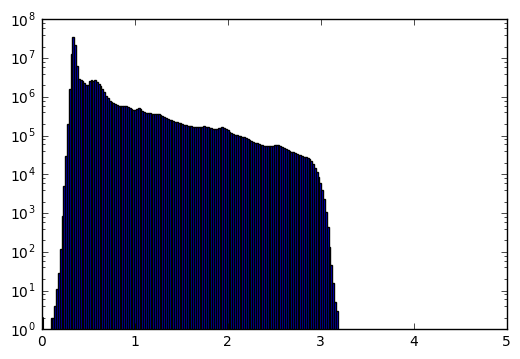

In [13]:
# calculate minus log of normalised images
proj_minus_log = tomopy.minus_log(proj_nor)

# the results have values of inf because of 0 in normalised images
varinfo(proj_minus_log)
plt.hist(proj_minus_log.ravel(), bins=256, range=(0,5), log=True)
plt.show()

Some pixels have value of **inf**, which will lead to **NAN** voxels resulting *missing* slices in the reconstruction. To avoid this, these **inf** values are replaced with a large number, and then replaced by the median value of neighour pixels. 

***Make sure there are no large numbers anymore, which otherwise will produce line artifacts!***

float32 (801, 370, 470) 0.0 3.16937


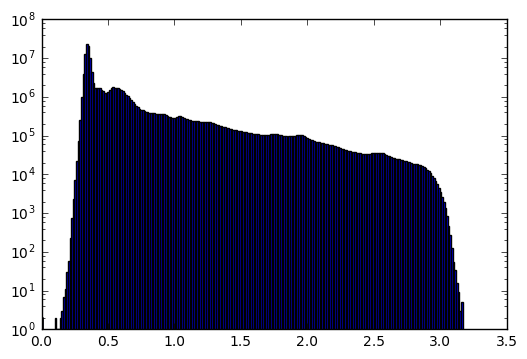

In [14]:
# replace inf with a large number
proj_minus_log = tomopy.adjust_range(proj_minus_log, dmin=0, dmax=100)
# replace these large numbers with median values of neighbours
proj_minus_log = tomopy.remove_outlier(proj_minus_log, dif=50, size=3)
# display the results
varinfo(proj_minus_log)
plt.hist(proj_minus_log.ravel(), bins=256, log=True)
plt.show()

## Reconstruction

In [15]:
# do reconstruction with gridrec and the default filter
rec = tomopy.recon(proj_minus_log, theta, center=center, algorithm='gridrec')

Apply circular mask. The rest pixels are replaced with value of the minimum of the reconstruction.

In [16]:
rec= tomopy.circ_mask(rec, axis=0, ratio=0.95, val=rec.min())

float32 (370, 470, 470) -0.0204084 0.0110136


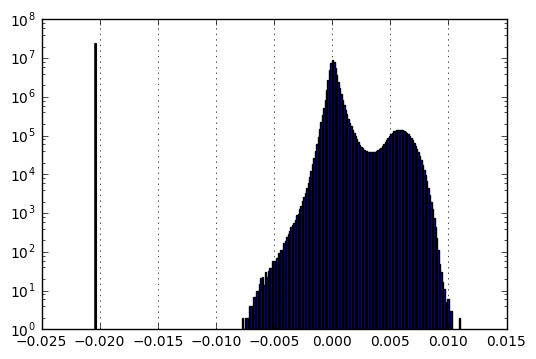

In [17]:
# display histogram of the reconstruction
varinfo(rec)
plt.hist(rec.ravel(), bins=256, log=True)
plt.gca().xaxis.grid(True)
plt.show()

Adjust the dynamic range.

In [18]:
rec = tomopy.adjust_range(rec, dmin=-0.001, dmax=0.009)
varinfo(rec)

float32 (370, 470, 470) -0.001 0.009


In [19]:
def disp_rec(i=150, vmin=rec.min(), vmax=rec.max()):
    plt.imshow(rec[i,:,:], cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()

ipywidgets.interact(disp_rec, 
                    i=(0,rec.shape[0]-1),
                    vmin=ipywidgets.FloatSlider(value=rec.min(), 
                                                min=rec.min(), max=rec.max(), step=0.001, 
                                                readout_format='.3f'), 
                    vmax=ipywidgets.FloatSlider(value=rec.max(), 
                                                min=rec.min(), max=rec.max(), step=0.001, 
                                                readout_format='.3f'))

<function __main__.disp_rec>

In [20]:
# save reconstructed images
tifffile.imsave(path_save + 'rec_v0.tiff', rec)

## Remove ring noise

In [21]:
rec = tifffile.imread(path_save + 'rec_v0.tiff')
rec_clean = tomopy.remove_ring(rec, thresh=0.0006)

In [22]:
def disp_rec_clean(i=150, vmin=rec.min(), vmax=rec.max()):
    plt.imshow(rec_clean[i,:,:], cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()
    
ipywidgets.interact(disp_rec_clean, 
                    i=(0,rec_clean.shape[0]-1),
                    vmin=ipywidgets.FloatSlider(value=rec_clean.min(), 
                                                min=rec.min(), max=rec.max(), step=0.001, 
                                                readout_format='.3f'), 
                    vmax=ipywidgets.FloatSlider(value=rec_clean.max(), 
                                                min=rec.min(), max=rec.max(), step=0.001, 
                                                readout_format='.3f'))

<function __main__.disp_rec_clean>

In [23]:
# save cleaned reconstructed images
tifffile.imsave(path_save + 'rec_v1.tiff', rec_clean)

## Output

In [24]:
rec = tifffile.imread(path_save + 'rec_v1.tiff')
rec_out = np.uint8((rec-rec.min())/(rec.max()-rec.min())*255)

uint8 (370, 470, 470) 0 255


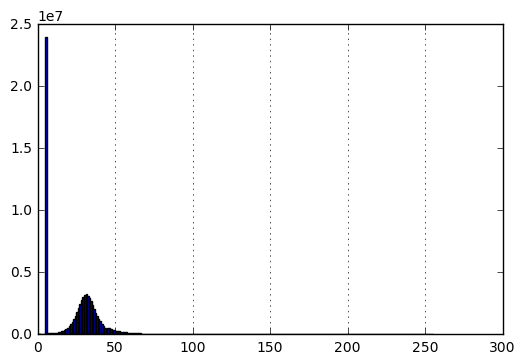

In [25]:
varinfo(rec_out)
plt.hist(rec_out.ravel(), bins=255, range=(1, 255))
plt.gca().xaxis.grid(True)
plt.show()

In [26]:
# save cleaned reconstructed images as 8-bit
tifffile.imsave(path_save + 'rec_out.tiff', rec_out)